# Exploring an Algal Bloom with Band Math
![bioscape](../PRISM/images/121229-87.png)

[**BioSCape**](https://www.bioscape.io/), the Biodiversity Survey of the Cape, is NASA’s first biodiversity-focused airborne and field campaign that was conducted in South Africa in 2023. BioSCape’s primary objective is to study the structure, function, and composition of the region’s ecosystems, and how and why they are changing. 

BioSCape's airborne dataset is unprecedented, with `AVIRIS-NG`, `PRISM`, and `HyTES` imaging spectrometers capturing spectral data across the UV, visible and infrared at high resolution and `LVIS` acquiring coincident full-waveform lidar. BioSCape's `field dataset` is equally impressive, with 18 PI-led projects collecting data ranging from the diversity and phylogeny of plants, kelp and phytoplankton, eDNA, landscape acoustics, plant traits, blue carbon accounting, and more

This workshop will equip participants with the skills to find, subset, and visualize the various BioSCape field and airborne (imaging spectroscopy and full-waveform lidar) data sets. Participants will learn data skills through worked examples in terrestrial and aquatic ecosystems, including: wrangling lidar data, performing band math calculations, calculating spectral diversity metrics, spectral unmixing, machine learning and image classification, and mapping functional traits using partial least squares regression. The workshop format is a mix of expert talks and interactive coding notebooks and will be run through the BioSCape Cloud computing environment.

**Date:** October 9 - 11, 2024 Cape Town, South Africa</center>

**Host:** NASA’s Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), in close collaboration with BioSCape, the South African Environmental Observation Network (SAEON), the University of Wisconsin Madison (Phil Townsend), The Nature Conservancy (Glenn Moncrieff), the University of California Merced (Erin Hestir), the University of Cape Town (Jasper Slingsby), Jet Propulsion Laboratory (Kerry Cawse-Nicholson), and UNESCO.

**Instructors:** 
- In-person contributors: Anabelle Cardoso, Erin Hestir, Phil Townsend, Henry Frye, Glenn Moncrieff, Jasper Slingsby, Michele Thornton, Rupesh Shrestha
- Virtual contributors: Kerry Cawse-Nicholson, Nico Stork, Kyle Kovach

**Audience:** This training is primarily intended for government natural resource management agency representatives and field technicians in South Africa, as well as local academics and students, especially those connected to the BioSCape Team. 


## Exploring an algal bloom with PRISM data

### Overview

In November 2023 the BioSCape campaign captured a red tide event - a bloom of noctiluca scintillans in Gordon's Bay. 

![](images/PRISM_gordonbay_rgb.png)

RGB image of the PRISM data acquired over Gordon's Bay on November 15, 2023.

The event prompting local news outlets to report on residents' complaints over smells, and reminding local residents to avoid swimming in the area.

![](images/gordons_bay_news_image.jpeg)

Picture: Facebook/Anirie Taljaardt via [Daily Voice](https://www.dailyvoice.co.za/news/gordons-bay-red-tide-is-common-a5f8d660-4b58-4b41-8249-8566c1c6ce1a)

In this tutorial, we will practice opening PRISM data, and will learn how to apply simple band math statements and functions to an image to explore this algal bloom event in Gordon's Bay.

### Learning Objectives
1. Gain proficiency in accessing PRISM data through the SMCE and S3 server and querying bands
2. Gain proficiency in plotting image spectra for a specified pixel
3. Apply band math statements to PRISM data to map fluorescence line height, chlorophyll-a concentration and absorption by colored dissolved organic matter
4. Gain proficiency in exporting derived maps as GeoTIFFs.

### Requirements

In [8]:
import s3fs
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import pandas as pd
from os import path
import rioxarray
gdal.UseExceptions()

### Content

At this point, you should be increasingly familiar with accessing BioSCape data through the SMCE and S3 cloud storage service. As a reminder, SMCE = Science Managed Cloud Environment S3 = Amazon Simple Storage Service (S3) is a cloud storage service that allows users to store and retrieve data S3Fs is a Pythonic open source tool that mounts S3 object storage locally. S3Fs provides a filesystem-like interface for accessing objects on S3. The top-level class S3FileSystem holds connection information and allows typical file-system style operations like ls ls is a UNIX command to list computer files and directories

We are going to open a PRISM flightline acquired over Gordon's Bay on November 15, 2023.

Recall that we are accessing PRISM reflectance Data as a GDAL Raster Dataset. GDAL (Geospatial Data Abstraction Library) is a translator library for raster and vector geospatial data formats In this step, we will use GDAL to examine the PRISM reflectance data that is in ENVI binary format (a proprietary, but common distribution format)

We need to configure our S3 credentials for GDAL The GDAL utility expects S3 links to be formated with the GDAL virtual file system (VSI) S3 path. We therefore have to use the VSI path to access the files with GDAL. We'll substitute the S3 link with the VSI (vsis3) link(s).

In [9]:
# Gordon's Bay scene
rfl_link = 'bioscape-data/PRISM/L2/prm20231115t092332_rfl_ort'

In [10]:
image_open = gdal.Open(path.join('/vsis3', rfl_link))
#image_open.GetMetadata()

Take note of the bands numbers and corresponding wavelengths we are printing. We are going to need this information for our analysis.  

In [11]:
# lists of band numbers and band center
band_numbers = [int(b.split("_")[1]) for b in image_open.GetMetadata().keys() if b != "wavelength_units"]
band_wavelength = [float(b.split(" ")[0]) for b in image_open.GetMetadata().values() if b != "Nanometers"]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band wavelength (nm)": band_wavelength}, index = band_wavelength).sort_index()

print(bands.to_string())

             Band number  Band wavelength (nm)
350.554829             1            350.554829
353.385086             2            353.385086
356.215399             3            356.215399
359.045768             4            359.045768
361.876193             5            361.876193
364.706675             6            364.706675
367.537213             7            367.537213
370.367807             8            370.367807
373.198457             9            373.198457
376.029164            10            376.029164
378.859927            11            378.859927
381.690746            12            381.690746
384.521621            13            384.521621
387.352553            14            387.352553
390.183541            15            390.183541
393.014585            16            393.014585
395.845685            17            395.845685
398.676841            18            398.676841
401.508054            19            401.508054
404.339323            20            404.339323
407.170649   

In [12]:
# need to sort the wavelengths for later plotting
band_wavelength.sort()
#print(band_wavelength)

In [13]:
# Open the PRISM ENVI file and read the file bands, row, cols
#image_open = gdal.Open(gdal_url)

nbands = image_open.RasterCount
nrows = image_open.RasterYSize
ncols = image_open.RasterXSize

print("\n".join(["Bands:\t"+str(nbands), "Rows:\t"+str(nrows), "Cols:\t"+str(ncols)]))

Bands:	246
Rows:	5459
Cols:	697


#### Compare Spectra from Two Pixels in the Bloom

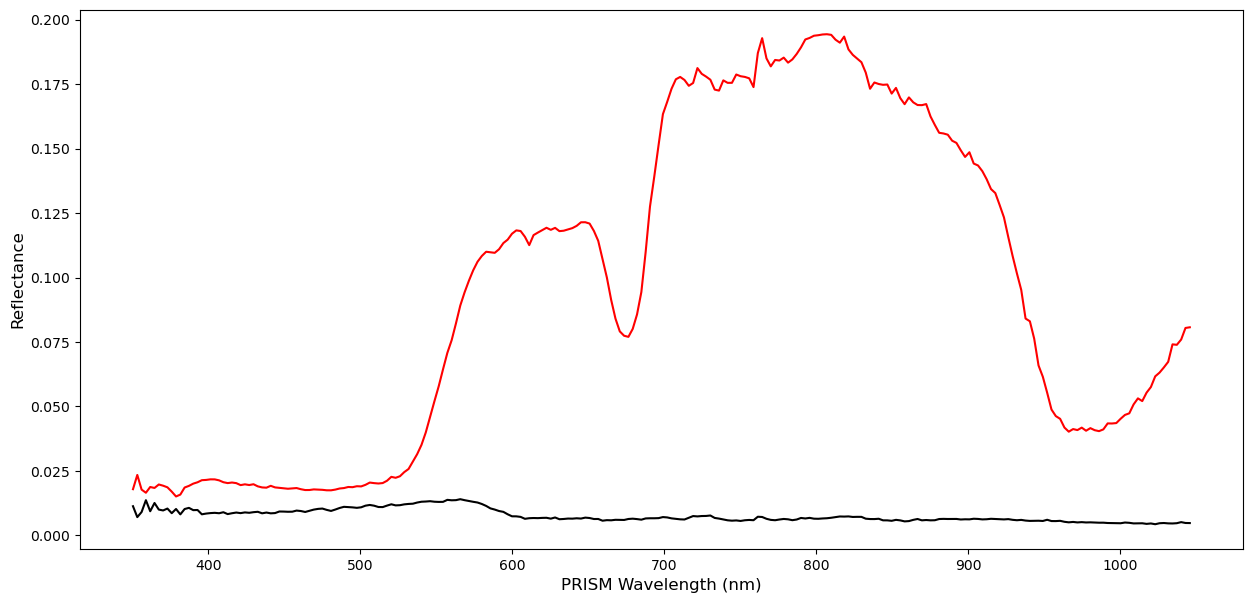

In [14]:
# Compare spectra of two different aquatic plots
pixel1 = image_open.ReadAsArray(393, 2487, 1, 1) #  pixel location: col, row
pixel2 = image_open.ReadAsArray(475, 2490, 1, 1) # pixel location: col, row
pixel1 = np.reshape(pixel1, (246))
pixel2 = np.reshape(pixel2, (246))

plt.rcParams['figure.figsize'] = [15,7]
plt.plot(band_wavelength, pixel1, color = 'red')
plt.plot(band_wavelength, pixel2, color = 'black')
plt.xlabel('PRISM Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.show()


This looks similar to field spectrscopy collected by [Mol et al. (2007)](https://odnature.naturalsciences.be/downloads/publications/online_241471.pdf) of a noctiluca bloom. 

This is a good sanity check!

![](images/Mol_et_al_2007.png)

### Calculate Fluorescence Line height (FLH)

The [Fluorescence Line Height] (FLH)(https://www.sciencedirect.com/science/article/pii/S0034425796000739) is typically calculated by estimating the height of the chlorophyll fluorescence peak at around 681 nm using two other bands on either side of this peak to form a baseline. 

![](images/FLH_concept.png)

Concept of the FLH measurement, taken from [Umamaheswara Rao et al. (2019)](https://link.springer.com/article/10.1007/s12524-019-01022-5). 

The chlorophyll fluoresence peak occurs around 681 nm. We select two bands on either side, typically around 665 nm (the lower wavelength band) and 750 nm (the higher wavelength band).

The general formula for FLH is:

$$ FLH = L_{fl} - \left(L_{low}+\frac{(\lambda_{fl}-\lambda_{low})}{(\lambda_{high}-\lambda_{low})}\right) \times (L_{high} - L_{low})$$

Where 
- $L_{fl}$ is the water-leaving radiance at the fluorescence peak (~681 nm)
- $L_{low}$ and $L_{high}$ are the radiance values at the shorter and longer wavelengths adjacent to the fluorescence band.
- $\lambda_{fl}$, $\lambda_{low}$, and $\lambda_{high}$ are the wavelengths corresponding to those bands.


#### A Note on Water Leaving Radiance vs Remote Sensing Reflectance
Fluorescence Line Height (FLH) is typically calculated using water-leaving radiance ($L_{w}$), not remote sensing reflectance ($R_{RS}$). The key difference is:
- Water-leaving radiance ($L_{w}$)is the radiance that exits the water and is detected by a satellite sensor after traveling through the atmosphere.
- Remote sensing reflectance ($R_{RS}$)is the ratio of water-leaving radiance to downwelling irradiance just above the surface of the water, representing a normalized reflectance value.
  
**Why Use Water-leaving Radiance for FLH?**
FLH measures the fluorescence signal of chlorophyll-a at around 681 nm. The calculation of FLH is done directly from the radiance values because the fluorescence signal itself is an addition to the radiance at that wavelength, caused by chlorophyll fluorescence in the water column. It captures the deviation in radiance at the chlorophyll fluorescence wavelength (around 681 nm) compared to the baseline radiance, which is estimated by interpolating between radiance at surrounding bands.

**How do we convert between $R_{RS}$ and $L_w$?**
$$ L_w = \pi R_{RS}$$



We are going to read in three bands 

In [15]:
img_665 = image_open.GetRasterBand(112).ReadAsArray()  # Band 112 is 665nm 
img_682 = image_open.GetRasterBand(118).ReadAsArray()  # Band 181 is 682nm
img_750 = image_open.GetRasterBand(142).ReadAsArray()  # Band 142 is 750nm

In [16]:
# Wavelength values (in nm)
lambda_low = 665
lambda_fl = 680
lambda_high = 750

# Convert RRS to Lw
img_682_Lw = img_682*np.pi
img_665_Lw = img_665*np.pi
img_750_Lw = img_750*np.pi


# Calculate FLH using the formula
FLH = img_682_Lw - (img_665_Lw + ((lambda_fl - lambda_low) / (lambda_high - lambda_low)) * (img_750_Lw - img_665_Lw))

In [17]:
# Compare FLH values of two different pixels
# Note here when we print an element in a numpy array, the order is row column 

pixel1 = FLH[2487, 393] #  pixel location: row, col
pixel2 = FLH[2490, 475] # pixel location: row, col

print("The FLH value at pixel 1 is " + str(pixel1))
print("The FLH value at pixel 2 is " + str(pixel2))

The FLH value at pixel 1 is -0.06581387
The FLH value at pixel 2 is 0.0016050916


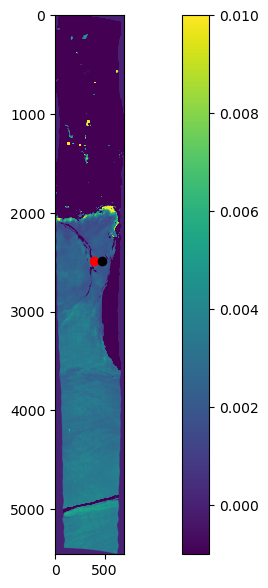

In [18]:
plt.scatter(393,2487, color='red')
plt.scatter(475, 2490, color='black')
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['figure.dpi'] = 100
plt.imshow(FLH, vmin=-0.001, vmax=0.01)
plt.colorbar()
plt.show()

In [28]:
![](images/FLH_map.png)

/bin/bash: -c: line 0: syntax error near unexpected token `images/FLH_map.png'
/bin/bash: -c: line 0: `[](images/FLH_map.png)'


### Calculate chlorophyll 

The [OC2 algorithm](https://www.sciencedirect.com/science/article/pii/S0034425796000739) is another empirical ocean color algorithm used to estimate chlorophyll-a concentration in ocean waters using a simple ratio of reflectance values from two spectral bands. OC2 typically uses two wavelengths, such as 490 nm (blue) and 555 nm (green). It is one of the oldest algorithms for chlorophyll-a, originally developed for the SeaWIFS ocean color instrument.

The OC2 algorithm was designed for ocean color satellite sensors like SeaWiFS, MODIS, or Sentinel-3. It takes the ratio of blue to green reflectance and empirically relates that ratio to chlorophyll concentration. 

$$R = R_{490}/R_{555}$$

$$log_{10}(Chla) = a_0 + a_1 * log_{10}(R) + a_2 * (log_{10}(R))^2 + a_3 * (log_{10}(R))^3$$

Where:
- $R_{490}$ is the reflectance at 490 nm
- $R_{555}$ is the reflectance at 550 nm
- $a_0, a_1, a_2, a_3$ are empirically derrived coefficients for a specific sensor and region

In this case, we will use the coefficients for Sentinel-3 OLCI

- $a_0 = 0.238$
- $a_1 = -1.936$
- $a_2 = 1.762$
- $a_3 = -0.463$ 

The OC2 algorithm is a good choice for estimating chlorophyll concentration in open ocean and coastal areas where the water is relatively clear. For more complex environments, a different algorithm or recalibration might be necessary. For more on the ocean color chlorophyll algorithms, see this [recent overview](https://www.sciencedirect.com/science/article/pii/S003442571930166X?via%3Dihub).

We are going to read in two bands

In [19]:
img_489 = image_open.GetRasterBand(50).ReadAsArray()  # Band 50 is 489nm
img_560 = image_open.GetRasterBand(75).ReadAsArray()  # Band 75 is 560nm

In [20]:
# Calculate the ratio R between 490 nm and 560 nm reflectance
# Note that because we are calculating a ratio, conversion to/from Lw is not needed

R = img_489/img_560

# OC2 Coefficients for Sentinel-3 OLCI
a0, a1, a2, a3 = 0.238, -1.936, 1.762, -0.463

# Calculate log10(R)
log_R = np.log10(R)

# Estimate chlorophyll concentration (in mg/m^3) using the polynomial equation
log_C = a0 + a1 * log_R + a2 * log_R**2 + a3 * log_R**3
C = 10 ** log_C

In [21]:
# Compare Chl-a values of two different pixels
# Note here when we print an element in a numpy array, the order is row column 

pixel1 = log_C[2487, 393] #  pixel location: row, col
pixel2 = log_C[2490, 475] # pixel location: row, col

print("The log_C value at pixel 1 is " + str(pixel1))
print("The log_C value at pixel 2 is " + str(pixel2))

The log_C value at pixel 1 is 2.2050688
The log_C value at pixel 2 is 0.42584196


### Calculate Colored Dissolved Organic Matter 

Calculating colored dissolved organic matter using spectrally adjacent band ratios has been demonstrated to be very successful across a broad range of oceanic and coastal waters. Most CDOM algorithms take the general form of a ratio of blue and green bands, blue and red, or green and red. The ratio is then used in a power-law model or exponential decay model to calibrate to absorption by CDOM, with coefficients that are empirically derived from field data.

In this example, we will use 
[Housekeeper et al. 2021](https://www.sciencedirect.com/science/article/pii/S0034425720305289#bb0020) model. 

$$ a_{CDOM}(440nm) = a\left(\frac{R_{412}}{R_{670}}\right)^b$$

Where 

- $R_{412}$ is the reflectance at 412 nm
- $R_{670}$ is the reflectance at 670 nm
- $a = 0.010$ and $b = 0.036$

We are going to read in two bands

In [22]:
img_412 = image_open.GetRasterBand(23).ReadAsArray()  # Band 23 is 412nm
img_670 = image_open.GetRasterBand(114).ReadAsArray()  # Band 114 is 670nm

#### Define a Function for Band Math 

If you haven't noticed yet, we are essentially doing a lot of band math. Sometimes it can be more efficient and more elegant to **define a function** so we can apply it over and over again. We often want to use functions because they can:
- increase the reusibility of code
- save you a lot of time
- make your code look cleaner, and thus easier to troubleshoot and share with others

In the example below, I will define a function for our algorithm so you can see an example. 

In [23]:
# Function to calculate CDOM using a power law function of band ratios
def calculate_cdom_power_law(blue_band, green_band, a=1.0, b=1.5):
    """
    Calculates CDOM using a power law function of band ratios.
    
    Parameters:
    blue_band: np.array - Reflectance values from the blue band (e.g., 490 nm)
    green_band: np.array - Reflectance values from the green band (e.g., 560 nm)
    a: float - Coefficient scaling factor (default=1.0)
    b: float - Exponent for the power law (default=1.5)
    
    Returns:
    np.array: CDOM values
    """
    # Avoid division by zero and invalid values
    ratio = np.divide(blue_band, green_band, out=np.zeros_like(blue_band), where=green_band != 0)
    
    # Apply the power law equation
    cdom = a * np.power(ratio, b)
    
    return cdom

# Parameters for the power law algorithm (adjust based on calibration)
a = 0.01   # From Housekeeper et al. 2021
b = 0.036  # From Housekeeper et al. 2021

# Calculate CDOM
cdom = calculate_cdom_power_law(img_412, img_670, a, b)


In [24]:
# Compare CDOM values of two different pixels
# Note here when we print an element in a numpy array, the order is row column 

pixel1 = cdom[2487, 393] #  pixel location: row, col
pixel2 = cdom[2490, 475] # pixel location: row, col

print("The CDOM value at pixel 1 is " + str(pixel1))
print("The CDOM value at pixel 2 is " + str(pixel2))

The CDOM value at pixel 1 is 0.009521637
The CDOM value at pixel 2 is 0.010113926


In [25]:
### Visualize all three maps side-by-side

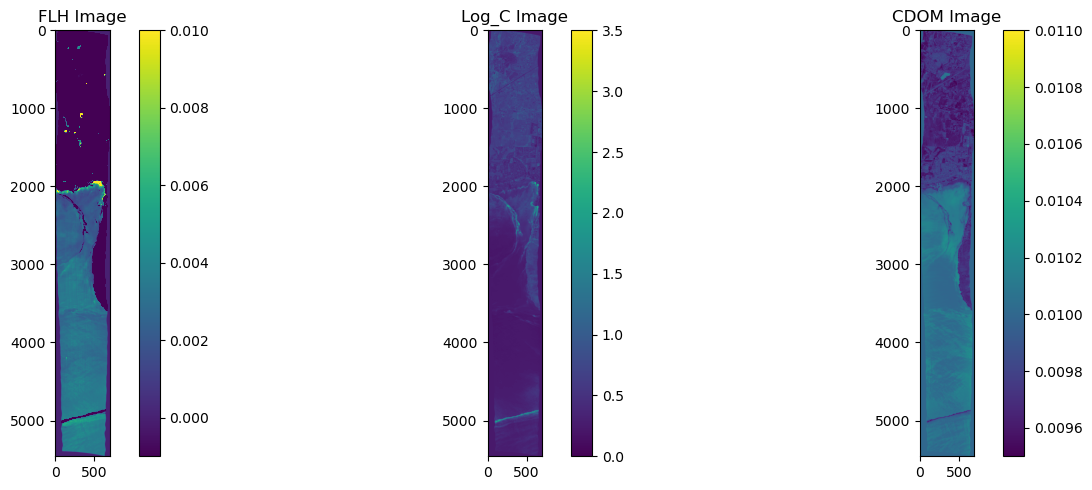

In [26]:
import matplotlib.pyplot as plt

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First subplot (FLH image with scatter points)
img1 = axes[0].imshow(FLH, vmin=-0.001, vmax=0.01)
fig.colorbar(img1, ax=axes[0])
axes[0].set_title('FLH Image')

# Second subplot (log_C image with scatter points)
img2 = axes[1].imshow(log_C, vmin=0, vmax=3.5)
fig.colorbar(img2, ax=axes[1])
axes[1].set_title('Log_C Image')

# Third subplot (cdom image with scatter points)
img3 = axes[2].imshow(cdom, vmin=0.0095, vmax=0.011)
fig.colorbar(img3, ax=axes[2])
axes[2].set_title('CDOM Image')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


![](images/gordons_bay_3_maps.png)

### Export turbidity maps as a stacked projected geoTIFFs

In [27]:
img_red = image_open.GetRasterBand(105).ReadAsArray()  # Band 105 is 645nm red

outfile = ('prism_bloom.tif')
rows = image_open.RasterYSize
cols = image_open.RasterXSize
datatype = image_open.GetRasterBand(1).DataType
projection = image_open.GetProjection()
transform = image_open.GetGeoTransform()

driver = gdal.GetDriverByName("GTiff")
DataSetOut = driver.Create(outfile, cols, rows, 2, datatype) # 3 band stack
DataSetOut.GetRasterBand(1).WriteArray(FLH) # note the order of the band stack
DataSetOut.GetRasterBand(2).WriteArray(log_C)
DataSetOut.GetRasterBand(2).WriteArray(cdom)
DataSetOut.SetProjection(projection)
DataSetOut.SetGeoTransform(transform)
DataSetOut = None